In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img,img_to_array

In [2]:
# Create a list with the filepaths for training and testing
train_dir = Path('..\\dataset//train')
train_filepaths = list(train_dir.glob(r'**/*.jpg'))

In [3]:
test_dir = Path('..\\dataset//test')
test_filepaths = list(test_dir.glob(r'**/*.jpg'))

In [4]:
val_dir = Path('..\\dataset//validation')
val_filepaths = list(test_dir.glob(r'**/*.jpg'))

In [5]:
def image_processing(filepath):
    """ Create a DataFrame with the filepath and the labels of the pictures
    """

    labels = [str(filepath[i]).split("\\")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop = True)
    
    return df

In [6]:
train_df = image_processing(train_filepaths)
test_df = image_processing(test_filepaths)
val_df = image_processing(val_filepaths)

In [7]:
print('-- Training set --\n')
print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels: {train_df.Label.unique()}')

-- Training set --

Number of pictures: 2855

Number of different labels: 36

Labels: ['banana' 'bell pepper' 'pear' 'sweetcorn' 'paprika' 'beetroot' 'kiwi'
 'raddish' 'jalepeno' 'cabbage' 'lettuce' 'cucumber' 'soy beans' 'corn'
 'sweetpotato' 'pineapple' 'ginger' 'pomegranate' 'onion' 'spinach'
 'eggplant' 'potato' 'cauliflower' 'mango' 'tomato' 'watermelon' 'lemon'
 'apple' 'chilli pepper' 'grapes' 'capsicum' 'garlic' 'orange' 'peas'
 'carrot' 'turnip']


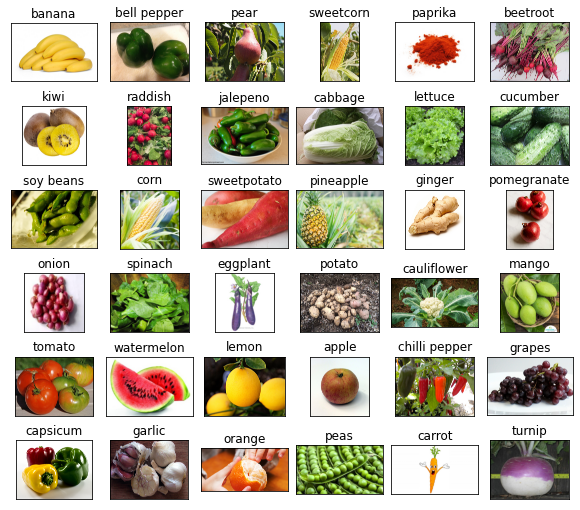

In [8]:
train_df# Create a DataFrame with one Label of each category
df_unique = train_df.copy().drop_duplicates(subset=["Label"]).reset_index()

# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(8, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.Filepath[i]))
    ax.set_title(df_unique.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

In [9]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [10]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

Found 2855 validated image filenames belonging to 36 classes.


In [11]:
val_images = train_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

Found 340 validated image filenames belonging to 36 classes.


In [12]:
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 340 validated image filenames belonging to 36 classes.


In [13]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

In [14]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(36, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=5,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)

Epoch 1/5
90/90 [==============================] - 402s 4s/step - loss: 1.8210 - accuracy: 0.5317 - val_loss: 0.4710 - val_accuracy: 0.8794
Epoch 2/5
90/90 [==============================] - 369s 4s/step - loss: 0.6006 - accuracy: 0.8053 - val_loss: 0.3237 - val_accuracy: 0.9029
Epoch 3/5
90/90 [==============================] - 371s 4s/step - loss: 0.3671 - accuracy: 0.8837 - val_loss: 0.2457 - val_accuracy: 0.9294
Epoch 4/5
90/90 [==============================] - 378s 4s/step - loss: 0.2453 - accuracy: 0.9215 - val_loss: 0.2067 - val_accuracy: 0.9382
Epoch 5/5
90/90 [==============================] - 365s 4s/step - loss: 0.1655 - accuracy: 0.9492 - val_loss: 0.1864 - val_accuracy: 0.9500


In [15]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)
# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred1 = [labels[k] for k in pred]
pred1

11/11 [==============================] - 54s 4s/step


['cabbage',
 'banana',
 'jalepeno',
 'grapes',
 'pomegranate',
 'onion',
 'carrot',
 'tomato',
 'eggplant',
 'mango',
 'pear',
 'lettuce',
 'garlic',
 'kiwi',
 'chilli pepper',
 'sweetcorn',
 'beetroot',
 'capsicum',
 'banana',
 'orange',
 'onion',
 'carrot',
 'sweetcorn',
 'chilli pepper',
 'pomegranate',
 'raddish',
 'garlic',
 'mango',
 'paprika',
 'cauliflower',
 'cucumber',
 'banana',
 'corn',
 'onion',
 'garlic',
 'kiwi',
 'raddish',
 'cucumber',
 'lettuce',
 'pomegranate',
 'mango',
 'sweetcorn',
 'peas',
 'tomato',
 'lettuce',
 'eggplant',
 'paprika',
 'lettuce',
 'paprika',
 'watermelon',
 'banana',
 'pomegranate',
 'cauliflower',
 'kiwi',
 'jalepeno',
 'jalepeno',
 'sweetcorn',
 'soy beans',
 'onion',
 'mango',
 'raddish',
 'beetroot',
 'banana',
 'paprika',
 'spinach',
 'kiwi',
 'potato',
 'bell pepper',
 'apple',
 'garlic',
 'lemon',
 'pineapple',
 'sweetcorn',
 'soy beans',
 'grapes',
 'cabbage',
 'jalepeno',
 'cauliflower',
 'jalepeno',
 'grapes',
 'sweetcorn',
 'tomato',

In [16]:
def output(location):
    img=load_img(location,target_size=(224,224,3))
    img=img_to_array(img)
    img=img/255
    img=np.expand_dims(img,[0])
    answer=model.predict(img)
    y_class = answer.argmax(axis=-1)
    y = " ".join(str(x) for x in y_class)
    y = int(y)
    res = labels[y]
    return res

In [17]:
img = output('dataset\\test\\soy beans\\Image_1.jpg')
img

FileNotFoundError: [Errno 2] No such file or directory: 'dataset\\test\\soy beans\\Image_1.jpg'

In [53]:
model.save('Fruit_Recognition.h5')